In [16]:
import gzip

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binomtest 
from statsmodels.stats import multitest

pd.set_option("display.max_columns", None)

Read thresholded dataframe with LOH positions

In [4]:
threshold = 40
folder = "LOH_pos_mmml_thresholded"
readfile = f"/home/junkhann/daten/{folder}/LOH_positions_threshold_{threshold}.tsv.gz"

In [5]:
df = pd.read_csv(readfile, sep="\t", compression="gzip")
len(df)

211336

In [6]:
def get_number_ref_alleles(entry: str) -> int:
    return entry.split(",")[0]

In [7]:
def get_number_alt_alleles(entry: str) -> int:
    return entry.split(",")[1]

In [8]:
# tumor_genotype field is "ref,alt"
df["n_ref_alleles"] = df["tumor_genotype"].apply(get_number_ref_alleles)
df["n_alt_alleles"] = df["tumor_genotype"].apply(get_number_alt_alleles)

In [9]:
df.head()

,#CHROM,pos_x,REF,ALT,INFO,sample_control,sample_tumor,start,end,genotype,TCN,PID,normal_genotype,tumor_genotype,quality_score,reads_normal,reads_tumor,position_code,pos_y,position_count,n_ref_alleles,n_alt_alleles
0,14,106242491,G,A,BRF=0.4;FR=0.6315;HP=1;HapScore=2;MGOF=19;MMLQ...,"1/0:-70.27,0,-7.37:8:74:28:24","1/0:-38.79,0,-0.19:19:4:13:12",106240304,106327227,1:0,1.0,4100314,"1,1","0,1",81.920024,28.0,13,14-106242491,14-106242491,53,0,1
1,14,106242491,G,A,BRF=0.28;FR=0.5;HP=1;HapScore=2;MGOF=14;MMLQ=3...,"1/0:-47.58,0,-9.98:9:99:24:17","1/0:-23.98,0,-31.38:14:99:21:10",106212572,106326383,1:0,1.0,4104893,"1,1","1,0",8.538720,24.0,21,14-106242491,14-106242491,53,1,0
2,14,106242491,G,A,BRF=0.29;FR=0.5;HP=1;HapScore=2;MGOF=10;MMLQ=3...,"1/0:-84.39,0,-14.69:4:99:34:27","1/0:-41.48,0,-26.58:10:99:23:14",106211749,106325302,1:0,1.0,4105746,"1,1","0,1",26.880100,34.0,23,14-106242491,14-106242491,53,0,1
3,14,106242491,G,A,BRF=0.37;FR=0.5008;HP=1;HapScore=1;MGOF=7;MMLQ...,"1/0:-94.29,0,-2.49:7:25:37:32","1/0:-60.46,0,-6.36:0:64:23:19",106237837,106329990,1:0,1.0,4108101,"1,1","0,1",46.470588,37.0,23,14-106242491,14-106242491,53,0,1
4,14,106242491,G,A,BRF=0.65;FR=0.5;HP=1;HapScore=2;MGOF=12;MMLQ=3...,"1/0:-52.88,0,-8.58:12:86:23:19","1/0:-39.89,0,-4.19:7:42:14:12",106176031,106324904,1:0,1.0,4108627,"1,1","0,1",85.387196,23.0,14,14-106242491,14-106242491,53,0,1


In [11]:
len(df[df["n_alt_alleles"] == "0"])

142559

Perform binomial test for each position

In [12]:
def get_p_value(df_position: pd.DataFrame) -> tuple[float, float]:
    n = len(df_position)
    df_loss_ref = df_position[df_position["n_alt_alleles"] == "0"]
    k = len(df_loss_ref)
    result = binomtest(k=k, n=n, p=0.5, alternative="greater")
    return result.pvalue

In [13]:
p_values = df.groupby("position_code").apply(get_p_value)

Plot p-values

<Axes: title={'center': 'Distribution of p-values'}, xlabel='p-value', ylabel='Frequency'>

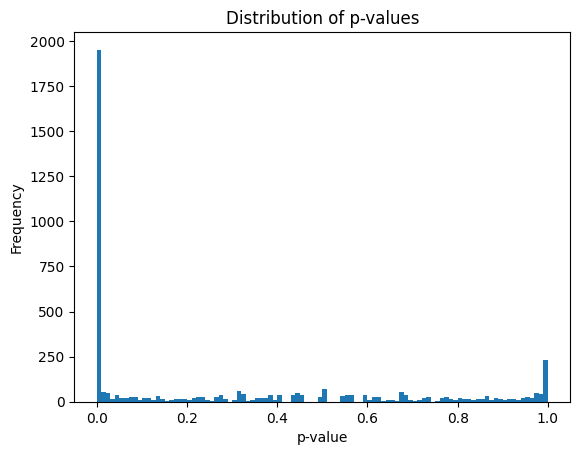

In [18]:
p_values.plot(kind="hist", bins=100, title="Distribution of p-values", xlabel="p-value")

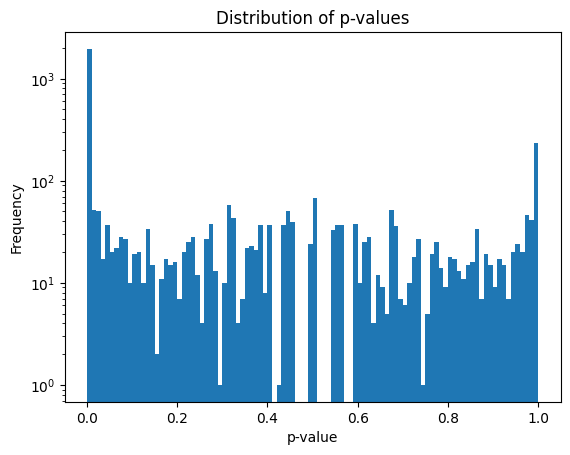

In [17]:
p_values.plot(kind="hist", bins=100, title="Distribution of p-values", xlabel="p-value")
plt.yscale("log")

Benjamini-Hochberg correction for multiple testing

In [19]:
rejected, adjusted_p_values, _, _ = multitest.multipletests(p_values, method='fdr_bh')

In [20]:
adjusted_p_values.plot(kind="hist", bins=100, title="Distribution of p-values (adjusted by Benjamini-Hochberg)", xlabel="adjusted p-value")

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

Text(0.5, 1.0, 'Distribution of p-values (adjusted by Benjamini-Hochberg correction)')

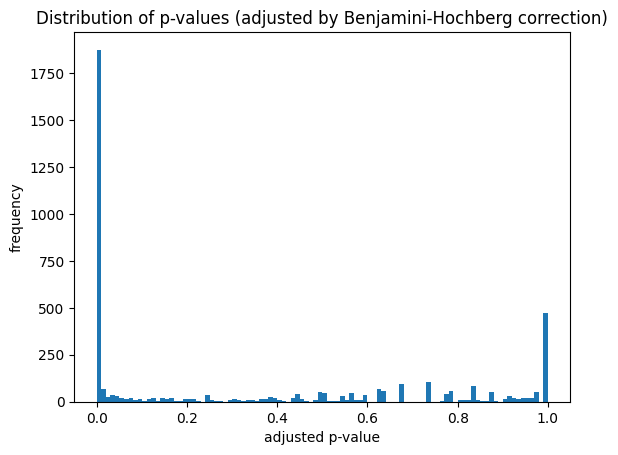

In [25]:
plt.hist(adjusted_p_values, bins=100)
plt.xlabel("adjusted p-value")
plt.ylabel("frequency")
plt.title("Distribution of p-values (adjusted by Benjamini-Hochberg correction)")

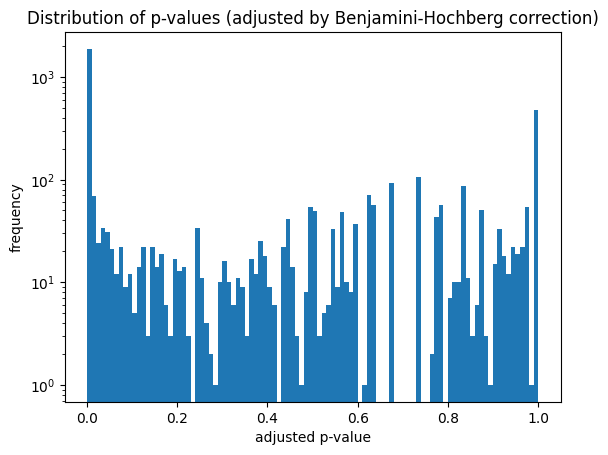

In [26]:
plt.hist(adjusted_p_values, bins=100)
plt.xlabel("adjusted p-value")
plt.ylabel("frequency")
plt.title("Distribution of p-values (adjusted by Benjamini-Hochberg correction)")
plt.yscale("log")